In [1]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping


data = loadmat("data/monkeydata.mat")['trial']

X, y = [], []

for trials in data:
    for target, trial in enumerate(trials):
        X.append(trial[1])
        y.append(target)
        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1234, shuffle=True)
print(f"Train: {len(y_train)} Valid: {len(y_valid)} Test: {len(y_test)}")

Train: 576 Valid: 64 Test: 160


<AxesSubplot:>

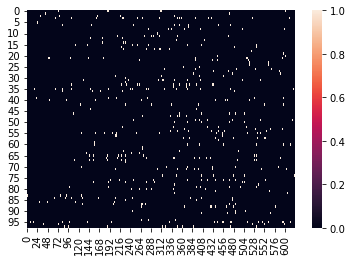

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(X_train[0])

In [2]:
class NeuralDataset(Dataset):
    def __init__(self, X, y, max_seq_len=1000):
        X_ = []

        for x in X:
            x_proced = np.pad(x, ((0, 0), (max_seq_len - x.shape[1], 0)), 'constant', constant_values=0)
            X_.append(x_proced)
        
        self.X = torch.tensor(X_, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)
        
        
    def __len__(self):
        return self.X.shape[0]
    
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        return x, y
    

train_dataset = NeuralDataset(X_train, y_train, max_seq_len=1000)
train_dataloader = DataLoader(train_dataset, batch_size=32)

valid_dataset = NeuralDataset(X_valid, y_valid, max_seq_len=1000)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)

test_dataset = NeuralDataset(X_train, y_train, max_seq_len=1000)
train_dataloader = DataLoader(test_dataset, batch_size=32)

In [6]:
class SimpleDNN(nn.Module):
    def __init__(self, channels=98):
        super(SimpleDNN, self).__init__()
        self.rnn = nn.GRU(98, 256, num_layers=2, batch_first=True)
        self.out = nn.Linear(256, 8)
        self.activation = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        x = F.max_pool1d(x, 10, 8)
        x = torch.swapaxes(x, 1, 2)
        x, _ = self.rnn(x)
        x = self.activation(x)
        x = torch.swapaxes(x, 1, 2)
        x = torch.mean(x, axis=2)
        x = self.out(x)
        
        return x


In [7]:
class Classifier(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super(Classifier, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        
        self.train_accuracy = torchmetrics.Accuracy()
        self.valid_accuracy = torchmetrics.Accuracy()
        self.test_accuracy = torchmetrics.Accuracy()
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        self.log("train_accuracy", self.train_accuracy(y_hat, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("valid_loss", loss)
        self.log("valid_accuracy", self.valid_accuracy(y_hat, y), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", self.test_accuracy(y_hat, y), on_step=False, on_epoch=True, prog_bar=True, logger=True)
          
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}



In [8]:
model = SimpleDNN()
classifer = Classifier(model, 0.00001)
trainer = pl.Trainer(accelerator="cpu", devices=1, max_epochs=20, enable_progress_bar=True)
trainer.fit(classifer, train_dataloader, valid_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name           | Type      | Params
---------------------------------------------
0 | model          | SimpleDNN | 670 K 
1 | train_accuracy | Accuracy  | 0     
2 | valid_accuracy | Accuracy  | 0     
3 | test_accuracy  | Accuracy  | 0     
---------------------------------------------
670 K     Trainable params
0         Non-trainable params
670 K     Total params
2.681     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]